In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from math import comb  # Combinations

from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

#from utils.subspace_clustering_helper_funcs import *
#from utils.ae_eval_and_vis import *
from utils.ae_torch_classes import *
from utils.LSTM_gesture_classifier import *

In [2]:
from itertools import combinations

In [3]:
import warnings
warnings.filterwarnings('ignore')
# C:\Users\kdmen\miniconda3\envs\fl_torch\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning warnings.warn(

In [4]:
print("Loading")

# Kai's laptop
#data_path = "C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\PCA_40D\\"
#model_dir_path = 'C:\\Users\\kdmen\\Desktop\\Research\\Repos\\fl-gestures\\models\\Embedding\\Autoencoders\\'
# BRC Desktop
data_path = "D:\\Kai_MetaGestureClustering_24\\saved_datasets\\"
model_dir_path = 'C:\\Users\\YamagamiLab\\Desktop\\Dev\\fl-gestures\\models\\Embedding\\Autoencoders\\'

emg_dir = "filtered_datasets\\EMG_PPD\\"
both_dir = "filtered_datasets\\Both_PPD\\"

metadata_cols = ['Participant', 'Gesture_ID', 'Gesture_Num']
metadata_cols_df = pd.read_pickle('D:\\Kai_MetaGestureClustering_24\\saved_datasets\\metadata_cols_df.pkl')

emg_training_users_df = pd.read_pickle(data_path+emg_dir+'training_users_df.pkl').drop(metadata_cols, axis=1)
emg_test_users_df = pd.read_pickle(data_path+emg_dir+'test_users_df.pkl').drop(metadata_cols, axis=1)

both_training_users_df = pd.read_pickle(data_path+both_dir+'training_users_df.pkl').drop(metadata_cols, axis=1)
both_test_users_df = pd.read_pickle(data_path+both_dir+'test_users_df.pkl').drop(metadata_cols, axis=1)


Loading


In [5]:
num_rows_per_gesture = 64 # From the interp
batch_size = 32

## Train/test Split
> Train set:

        - Full dataset XOR all testsets
> Test sets:

        - Last 2 trials of all gestures
        - Hold out 5 users

In [6]:
combined_emg_df = pd.concat([metadata_cols_df, pd.concat([emg_training_users_df, emg_test_users_df])], axis=1)

print(combined_emg_df.shape)
combined_emg_df.head()

(204800, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,-0.362743,-0.801651,-0.383077,-0.195299,-0.203047,-0.464472,-0.276292,-0.026736,-0.873870,-1.036152,-0.580930,-0.719494,-0.502255,-1.750091,-0.127847,-0.094192
1,P102,pan,1,-0.351553,-0.775334,-0.382545,-0.154773,-0.131977,-0.295204,-0.125822,0.089679,-0.816215,-2.082635,-0.006283,-0.139439,-0.367764,-0.208084,-0.111811,-0.039009
2,P102,pan,1,-0.380825,-0.762588,-0.398388,-0.085411,0.017528,-0.205675,-0.068451,0.117076,-0.668221,-3.403064,-0.526030,-0.478294,-0.300443,0.203266,0.113300,0.004728
3,P102,pan,1,-0.366795,-0.765464,-0.374423,-0.073225,0.183172,0.009277,-0.058907,0.080977,-0.424416,-3.709413,-0.570894,-0.775155,-0.144710,-0.619539,0.146499,0.199975
4,P102,pan,1,-0.245578,-0.761283,-0.303976,-0.081947,0.224996,0.103319,-0.003929,0.041526,-0.016530,-4.075150,-0.127710,2.682791,-0.141750,-0.208404,-0.035642,0.172662


In [7]:
unique_gestures = combined_emg_df['Gesture_ID'].unique()
unique_gestures

array(['pan', 'duplicate', 'zoom-out', 'zoom-in', 'move', 'rotate',
       'select-single', 'delete', 'close', 'open'], dtype=object)

Held Out Users Test Set

In [8]:
combined_emg_df['Participant'].unique()

array(['P102', 'P103', 'P104', 'P105', 'P106', 'P107', 'P108', 'P109',
       'P110', 'P111', 'P112', 'P114', 'P115', 'P116', 'P118', 'P119',
       'P121', 'P122', 'P123', 'P124', 'P125', 'P126', 'P127', 'P128',
       'P131', 'P132', 'P004', 'P005', 'P006', 'P008', 'P010', 'P011'],
      dtype=object)

In [9]:
held_out_users_lst = ['P104', 'P108', 'P112', 'P116', 'P122', 'P124']
num_test_users = len(held_out_users_lst)
num_train_users = len(combined_emg_df['Participant'].unique()) - num_test_users
heldoutusers_testset = combined_emg_df[combined_emg_df['Participant'].isin(held_out_users_lst)].reset_index(drop=True)

print(heldoutusers_testset.shape)
heldoutusers_testset.head()

(38400, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P104,duplicate,1,-0.836866,-0.069462,-1.201111,-3.266425,-0.143297,-0.012325,-0.246586,-0.874835,-0.903565,-0.139702,-1.199692,-1.301382,-0.065817,-0.008174,-0.002584,-0.011676
1,P104,duplicate,1,-0.780875,-0.082351,-1.208023,-3.258212,-0.110423,0.003053,-0.248364,-1.083834,-0.897283,-0.124933,-1.195211,-1.293138,0.006040,0.004724,0.019656,-0.012380
2,P104,duplicate,1,-0.830069,-0.081989,-1.250259,-3.157837,-0.129984,0.019836,-0.245799,-1.099313,-0.811197,-0.097231,-1.089515,-1.219655,-0.024191,0.015596,-0.015494,0.036700
3,P104,duplicate,1,-0.913201,-0.070693,-1.233590,-2.898543,-0.208200,0.010882,-0.219394,-1.123904,-0.798595,-0.105790,-0.904317,-1.281031,-0.068723,0.011252,-0.005082,0.080905
4,P104,duplicate,1,-0.808832,-0.066996,-1.088678,-2.514705,-0.155542,0.002881,-0.109496,-0.220264,-0.821522,-0.105144,-0.440872,-1.288635,-0.060873,-0.015651,0.004653,0.041557


Last 2 Trials Test Set

In [10]:
# Should I be choosing random numbers? 9 and 10 are later so may be different from earlier trials...
# Let's try 4 and 7 instead...
held_out_trials_lst = ['4', '7']
num_train_trials = 10 - len(held_out_trials_lst)

heldouttrials_testset = combined_emg_df[combined_emg_df['Gesture_Num'].isin(held_out_trials_lst)].reset_index(drop=True)

print(heldouttrials_testset.shape)
heldouttrials_testset.head()

(40960, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,4,-0.549235,-0.916534,-0.525121,-0.225610,-0.333053,-0.760832,-0.375548,-0.062929,-0.920086,-2.385653,-0.381550,-0.731687,-0.268114,-0.740772,-0.129833,-0.103633
1,P102,pan,4,-0.490476,-0.890864,-0.483957,-0.225391,-0.214160,-0.579567,-0.256789,-0.087063,-0.702393,-3.445693,-0.257704,0.042039,-0.314467,-1.443360,0.066790,-0.013539
2,P102,pan,4,-0.514758,-0.890326,-0.451366,-0.185288,-0.066625,-0.421072,-0.291759,-0.034548,-0.506846,-3.134198,-0.350304,-0.132754,-0.268009,-2.053143,0.060545,0.006590
3,P102,pan,4,-0.536191,-0.864666,-0.372611,-0.103400,-0.037901,-0.213140,-0.286353,0.018436,-0.264826,-3.101445,-0.404368,4.729111,-0.164762,-0.629966,-0.092068,-0.054365
4,P102,pan,4,-0.241157,-0.623542,0.007789,-0.055446,-0.009482,-0.143867,-0.215939,0.076685,-0.147219,-3.332459,-0.486141,5.866592,-0.182525,-0.123562,0.087061,0.008114


Remove test users from held out trials (dont double dip test sets...)

In [11]:
heldouttrials_testset

# Drop rows where 'Participant' is in participants_to_drop
heldouttrials_testset = heldouttrials_testset[~heldouttrials_testset['Participant'].isin(held_out_users_lst)].reset_index(drop=True)

print(heldouttrials_testset.shape)
heldouttrials_testset.head()

(33280, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,4,-0.549235,-0.916534,-0.525121,-0.225610,-0.333053,-0.760832,-0.375548,-0.062929,-0.920086,-2.385653,-0.381550,-0.731687,-0.268114,-0.740772,-0.129833,-0.103633
1,P102,pan,4,-0.490476,-0.890864,-0.483957,-0.225391,-0.214160,-0.579567,-0.256789,-0.087063,-0.702393,-3.445693,-0.257704,0.042039,-0.314467,-1.443360,0.066790,-0.013539
2,P102,pan,4,-0.514758,-0.890326,-0.451366,-0.185288,-0.066625,-0.421072,-0.291759,-0.034548,-0.506846,-3.134198,-0.350304,-0.132754,-0.268009,-2.053143,0.060545,0.006590
3,P102,pan,4,-0.536191,-0.864666,-0.372611,-0.103400,-0.037901,-0.213140,-0.286353,0.018436,-0.264826,-3.101445,-0.404368,4.729111,-0.164762,-0.629966,-0.092068,-0.054365
4,P102,pan,4,-0.241157,-0.623542,0.007789,-0.055446,-0.009482,-0.143867,-0.215939,0.076685,-0.147219,-3.332459,-0.486141,5.866592,-0.182525,-0.123562,0.087061,0.008114


Make train set now!

In [12]:
# Concatenate the smaller dataframes
combined_testsets = pd.concat([heldouttrials_testset, heldoutusers_testset]).drop_duplicates()

# Perform the anti-join
result_df = combined_emg_df.merge(combined_testsets, on=['Participant', 'Gesture_ID', 'Gesture_Num', 'EMG1', 'EMG2', 'EMG3',
                                                   'EMG4', 'EMG5', 'EMG6', 'EMG7', 'EMG8', 'EMG9', 'EMG10', 'EMG11',
                                                   'EMG12', 'EMG13', 'EMG14', 'EMG15', 'EMG16'],
                           how='left', indicator=True)
trainset = result_df[result_df['_merge'] == 'left_only'].drop(columns=['_merge'])

# Display the result
print(trainset.shape)
trainset.head()

(133120, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,-0.362743,-0.801651,-0.383077,-0.195299,-0.203047,-0.464472,-0.276292,-0.026736,-0.873870,-1.036152,-0.580930,-0.719494,-0.502255,-1.750091,-0.127847,-0.094192
1,P102,pan,1,-0.351553,-0.775334,-0.382545,-0.154773,-0.131977,-0.295204,-0.125822,0.089679,-0.816215,-2.082635,-0.006283,-0.139439,-0.367764,-0.208084,-0.111811,-0.039009
2,P102,pan,1,-0.380825,-0.762588,-0.398388,-0.085411,0.017528,-0.205675,-0.068451,0.117076,-0.668221,-3.403064,-0.526030,-0.478294,-0.300443,0.203266,0.113300,0.004728
3,P102,pan,1,-0.366795,-0.765464,-0.374423,-0.073225,0.183172,0.009277,-0.058907,0.080977,-0.424416,-3.709413,-0.570894,-0.775155,-0.144710,-0.619539,0.146499,0.199975
4,P102,pan,1,-0.245578,-0.761283,-0.303976,-0.081947,0.224996,0.103319,-0.003929,0.041526,-0.016530,-4.075150,-0.127710,2.682791,-0.141750,-0.208404,-0.035642,0.172662


In [13]:
trainset_metadata = trainset.iloc[::num_rows_per_gesture, :3]

print(trainset_metadata.shape)
trainset_metadata.head()

(2080, 3)


,Participant,Gesture_ID,Gesture_Num
0,P102,pan,1
64,P102,pan,2
128,P102,pan,3
256,P102,pan,5
320,P102,pan,6


Encode the labels

In [14]:
# THESE ARE LABELS BY GESTURE!

label_encoder = LabelEncoder()
label_encoder.fit(unique_gestures)

# Transform the gesture labels in each dataset
train_labels = label_encoder.transform(trainset['Gesture_ID'].iloc[::num_rows_per_gesture])
testHOT_labels = label_encoder.transform(heldouttrials_testset['Gesture_ID'].iloc[::num_rows_per_gesture])
testHOU_labels = label_encoder.transform(heldoutusers_testset['Gesture_ID'].iloc[::num_rows_per_gesture])

print(f"train_labels shape: {train_labels.shape}")
print(f"testHOT_labels shape: {testHOT_labels.shape}")
print(f"testHOU_labels shape: {testHOU_labels.shape}")


train_labels shape: (2080,)
testHOT_labels shape: (520,)
testHOU_labels shape: (600,)


In [15]:
train_labels[:5]

array([5, 5, 5, 5, 5])

In [16]:
testHOT_labels[:5]

array([5, 5, 2, 2, 9])

In [17]:
testHOU_labels[:5]

array([2, 2, 2, 2, 2])

In [18]:
# CREATE THE TRAINING SET
num_train_gestures = len(trainset) // num_rows_per_gesture
num_emg_features = emg_training_users_df.shape[1]
num_HOT_gestures = len(heldouttrials_testset) // num_rows_per_gesture
num_HOU_gestures = len(heldoutusers_testset) // num_rows_per_gesture

print(num_train_gestures)
print(num_HOT_gestures)
print(num_HOU_gestures)

2080
520
600


In [19]:
X_3DTensor_full_emg = torch.tensor(trainset.iloc[:,3:].to_numpy().reshape(num_train_gestures, num_rows_per_gesture, num_emg_features), dtype=torch.float32)
Xtest_3DTensor_HOT = torch.tensor(heldouttrials_testset.iloc[:,3:].to_numpy().reshape(num_HOT_gestures, num_rows_per_gesture, num_emg_features), dtype=torch.float32)
Xtest_3DTensor_HOU = torch.tensor(heldoutusers_testset.iloc[:,3:].to_numpy().reshape(num_HOU_gestures, num_rows_per_gesture, num_emg_features), dtype=torch.float32)


In [20]:
hidden_dim_lst = [9]
input_dim = 16
RNNAE_9mir_EMGFull = RNNAutoencoder(input_dim, hidden_dim_lst, num_layers=None, seq_len=num_rows_per_gesture, progressive=False, mirror=True)
RNNAE_9mir_EMGFull.load_state_dict(torch.load(model_dir_path+'RNNAE_9mir_vallossp277_EMGFull.pth'))

<All keys matched successfully>

These are the input data embeddings

In [21]:
X_emg_train_embeddings = RNNAE_9mir_EMGFull.encode(X_3DTensor_full_emg)
X_emgHOT_test_embeddings = RNNAE_9mir_EMGFull.encode(Xtest_3DTensor_HOT)
X_emgHOU_test_embeddings = RNNAE_9mir_EMGFull.encode(Xtest_3DTensor_HOU)

print(f"X_emg_train_embeddings shape: {X_emg_train_embeddings.shape}")
print(f"X_emgHOT_test_embeddings shape: {X_emgHOT_test_embeddings.shape}")
print(f"X_emgHOU_test_embeddings shape: {X_emgHOU_test_embeddings.shape}")


X_emg_train_embeddings shape: torch.Size([2080, 64, 9])
X_emgHOT_test_embeddings shape: torch.Size([520, 64, 9])
X_emgHOU_test_embeddings shape: torch.Size([600, 64, 9])


In [30]:
520/2/10
# 640 / 2 trials held out per gesture / 10 gestures

# --> 26 is the number of train participants

26.0

In [22]:
num_embedded_emg_features = hidden_dim_lst[-1]

In [42]:
num_train_gestures_per_user = X_emg_train_embeddings.shape[0]//num_train_users
num_HOT_gestures_per_user = X_emgHOT_test_embeddings.shape[0]//num_train_users
num_HOU_gestures_per_user = X_emgHOU_test_embeddings.shape[0]//num_test_users

print(num_train_gestures_per_user)
print(num_HOT_gestures_per_user)
print(num_HOU_gestures_per_user)

80
20
100


- Each participant has their our HOT dataset and label set
- All participants share and test on the same HOU dataset and label set (these users are necessarily held out of the trianing user set to begin with)

In [43]:
ptrain_3D_dict = dict()
ptest_HOT3D_dict = dict()

ptrain_2D_dict = dict()
ptest_HOT2D_dict = dict()

ptrain_labels_dict = dict()
ptest_labelsHOT_dict = dict()

for p_idx, pID in enumerate(trainset_metadata['Participant'].unique()):
    lb = int(p_idx*num_train_gestures_per_user)
    ub = int(p_idx*num_train_gestures_per_user+num_train_gestures_per_user)
    HOT_lb = int(p_idx*num_HOT_gestures_per_user)
    HOT_ub = int(p_idx*num_HOT_gestures_per_user+num_HOT_gestures_per_user)
    print(f"pID: {pID}; lb: {lb}; ub: {ub}; HOT_lb: {HOT_lb}; HOT_lb: {HOT_lb}.")
    
    ptrain_3D_dict[pID] = X_emg_train_embeddings[lb:ub, :, :]
    ptest_HOT3D_dict[pID] = X_emgHOT_test_embeddings[HOT_lb:HOT_ub, :, :]

    ptrain_2D_dict[pID] = X_emg_train_embeddings[lb:ub, :, :].reshape(num_train_gestures_per_user, -1).detach().numpy()
    ptest_HOT2D_dict[pID] = X_emgHOT_test_embeddings[HOT_lb:HOT_ub, :, :].reshape(num_HOT_gestures_per_user, -1).detach().numpy()

    ptrain_labels_dict[pID] = train_labels[lb:ub]
    ptest_labelsHOT_dict[pID] = testHOT_labels[HOT_lb:HOT_ub]


pID: P102; lb: 0; ub: 80; HOT_lb: 0; HOT_lb: 0.
pID: P103; lb: 80; ub: 160; HOT_lb: 20; HOT_lb: 20.
pID: P105; lb: 160; ub: 240; HOT_lb: 40; HOT_lb: 40.
pID: P106; lb: 240; ub: 320; HOT_lb: 60; HOT_lb: 60.
pID: P107; lb: 320; ub: 400; HOT_lb: 80; HOT_lb: 80.
pID: P109; lb: 400; ub: 480; HOT_lb: 100; HOT_lb: 100.
pID: P110; lb: 480; ub: 560; HOT_lb: 120; HOT_lb: 120.
pID: P111; lb: 560; ub: 640; HOT_lb: 140; HOT_lb: 140.
pID: P114; lb: 640; ub: 720; HOT_lb: 160; HOT_lb: 160.
pID: P115; lb: 720; ub: 800; HOT_lb: 180; HOT_lb: 180.
pID: P118; lb: 800; ub: 880; HOT_lb: 200; HOT_lb: 200.
pID: P119; lb: 880; ub: 960; HOT_lb: 220; HOT_lb: 220.
pID: P121; lb: 960; ub: 1040; HOT_lb: 240; HOT_lb: 240.
pID: P123; lb: 1040; ub: 1120; HOT_lb: 260; HOT_lb: 260.
pID: P125; lb: 1120; ub: 1200; HOT_lb: 280; HOT_lb: 280.
pID: P126; lb: 1200; ub: 1280; HOT_lb: 300; HOT_lb: 300.
pID: P127; lb: 1280; ub: 1360; HOT_lb: 320; HOT_lb: 320.
pID: P128; lb: 1360; ub: 1440; HOT_lb: 340; HOT_lb: 340.
pID: P131; lb: 

In [ ]:
# ptest_HOU3D_dict --> X_emgHOU_test_embeddings
# ptest_HOU2D_dict --> X_emgHOU_test_embeddings.reshape(X_emgHOU_test_embeddings.shape[0], -1).detach().numpy()
#testHOU_labels

In [58]:
using_pytorch=False
k=1  # Change this to k_range in the future...
model_str='KNN'

########################################

participants = list(trainset_metadata['Participant'].unique())
num_participants = len(participants)
pairwise_model_HOTaccuracies_matrix = np.zeros((num_participants, num_participants))
pairwise_model_HOUaccuracies_matrix = np.zeros((num_participants, num_participants))
pairwise_model_AVGaccuracies_matrix = np.zeros((num_participants, num_participants))

# Iterate through every pair of participants
total_num_combos = comb(num_participants, 2)

if using_pytorch:
    testHOU_dataset = TensorDataset(X_emgHOU_test_embeddings, torch.tensor(testHOU_labels, dtype=torch.float32))
    testHOU_loader = DataLoader(testHOU_dataset, batch_size=batch_size, shuffle=False)
else:
    Xtest_HOU = X_emgHOU_test_embeddings.reshape(X_emgHOU_test_embeddings.shape[0], -1).detach().numpy()
    ytest_HOU = testHOU_labels.reshape(-1, 1)  # Make it 2D...
    
for current_combo_idx, (p1, p2) in enumerate(combinations(participants, 2)):
    if current_combo_idx%15==0:
        print(f"Pair {current_combo_idx+1} of {total_num_combos}: ({p1}, {p2})")
    p1_idx = participants.index(p1)
    p2_idx = participants.index(p2)

    if using_pytorch:
        # Create TensorDataset
        # NEED TO ADD LABELS!!!
        # NEED TO CORRECT pID TO p1 and p2 AND THEN CAT THE TENSORS!
        #torch.cat((tensor1, tensor2), dim=0)
        train_dataset = TensorDataset(ptrain_3D_dict[pID], torch.tensor(ptrain_labels_dict[pID], dtype=torch.float32))
        testHOT_dataset = TensorDataset( ptest_HOT3D_dict[pID], torch.tensor(ptest_labelsHOT_dict[pID], dtype=torch.float32))
        
        # Create DataLoader
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        testHOT_loader = DataLoader(testHOT_dataset, batch_size=batch_size, shuffle=False)

        # LSTM / NN code note added yet...
    
    else:
        Xtrain = np.concatenate((ptrain_2D_dict[p1], ptrain_2D_dict[p2]), axis=0)
        Xtest_HOT = np.concatenate((ptest_HOT2D_dict[p1], ptest_HOT2D_dict[p2]), axis=0)
        
        ytrain = np.concatenate((ptrain_labels_dict[p1].reshape(-1, 1), ptrain_labels_dict[p2].reshape(-1, 1)), axis=0)  # Make it 2D...
        ytest_HOT = np.concatenate((ptest_labelsHOT_dict[p1].reshape(-1, 1), ptest_labelsHOT_dict[p2].reshape(-1, 1)), axis=0)  # Make it 2D...

        if model_str.upper()=='KNN':
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(Xtrain, ytrain)
            
            y_pred = knn.predict(Xtest_HOT)
            HOT_accuracy = accuracy_score(ytest_HOT, y_pred)
            pairwise_model_HOTaccuracies_matrix[p2_idx, p1_idx] = HOT_accuracy
            pairwise_model_HOTaccuracies_matrix[p1_idx, p2_idx] = HOT_accuracy
            #print(f"Pair {current_combo_idx+1} of {total_num_combos}: ({p1}, {p2}): HOT_accuracy: {HOT_accuracy}")
            #print(f"HOT_accuracy: {HOT_accuracy}")
        
            y_pred = knn.predict(Xtest_HOU)
            HOU_accuracy = accuracy_score(ytest_HOU, y_pred)
            pairwise_model_HOUaccuracies_matrix[p2_idx, p1_idx] = HOU_accuracy
            pairwise_model_HOUaccuracies_matrix[p1_idx, p2_idx] = HOU_accuracy
            #print(f"HOU_accuracy: {HOU_accuracy}")

            AVG_accuracy = (HOT_accuracy + HOU_accuracy) / 2
            pairwise_model_AVGaccuracies_matrix[p2_idx, p1_idx] = AVG_accuracy
            pairwise_model_AVGaccuracies_matrix[p1_idx, p2_idx] = AVG_accuracy
        elif model_str.upper()=='SVC':
            svc = SVC(kernel='linear')
            svc.fit(Xtrain, ytrain)
            
            y_pred_HOT = svc.predict(Xtest_HOT)
            HOT_accuracy = accuracy_score(ytest_HOT, y_pred_HOT)
            pairwise_model_HOTaccuracies_matrix[p2_idx, p1_idx] = HOT_accuracy
            pairwise_model_HOTaccuracies_matrix[p1_idx, p2_idx] = HOT_accuracy
            
            y_pred_HOU = svc.predict(Xtest_HOU)
            HOU_accuracy = accuracy_score(ytest_HOU, y_pred_HOU)
            pairwise_model_HOUaccuracies_matrix[p2_idx, p1_idx] = HOU_accuracy
            pairwise_model_HOUaccuracies_matrix[p1_idx, p2_idx] = HOU_accuracy
            
            AVG_accuracy = (HOT_accuracy + HOU_accuracy) / 2
            pairwise_model_AVGaccuracies_matrix[p2_idx, p1_idx] = AVG_accuracy
            pairwise_model_AVGaccuracies_matrix[p1_idx, p2_idx] = AVG_accuracy
        else:
            raise ValueError(f"model_str {model_str} is not supported")
    


Pair 1 of 325: (P102, P103)
Pair 16 of 325: (P102, P127)
Pair 31 of 325: (P103, P111)
Pair 46 of 325: (P103, P006)
Pair 61 of 325: (P105, P125)
Pair 76 of 325: (P106, P111)
Pair 91 of 325: (P106, P006)
Pair 106 of 325: (P107, P127)
Pair 121 of 325: (P109, P119)
Pair 136 of 325: (P110, P111)
Pair 151 of 325: (P110, P006)
Pair 166 of 325: (P111, P132)
Pair 181 of 325: (P114, P128)
Pair 196 of 325: (P115, P127)
Pair 211 of 325: (P118, P127)
Pair 226 of 325: (P119, P128)
Pair 241 of 325: (P121, P132)
Pair 256 of 325: (P123, P006)
Pair 271 of 325: (P126, P127)
Pair 286 of 325: (P127, P006)
Pair 301 of 325: (P131, P006)
Pair 316 of 325: (P005, P006)


HOT Visualization

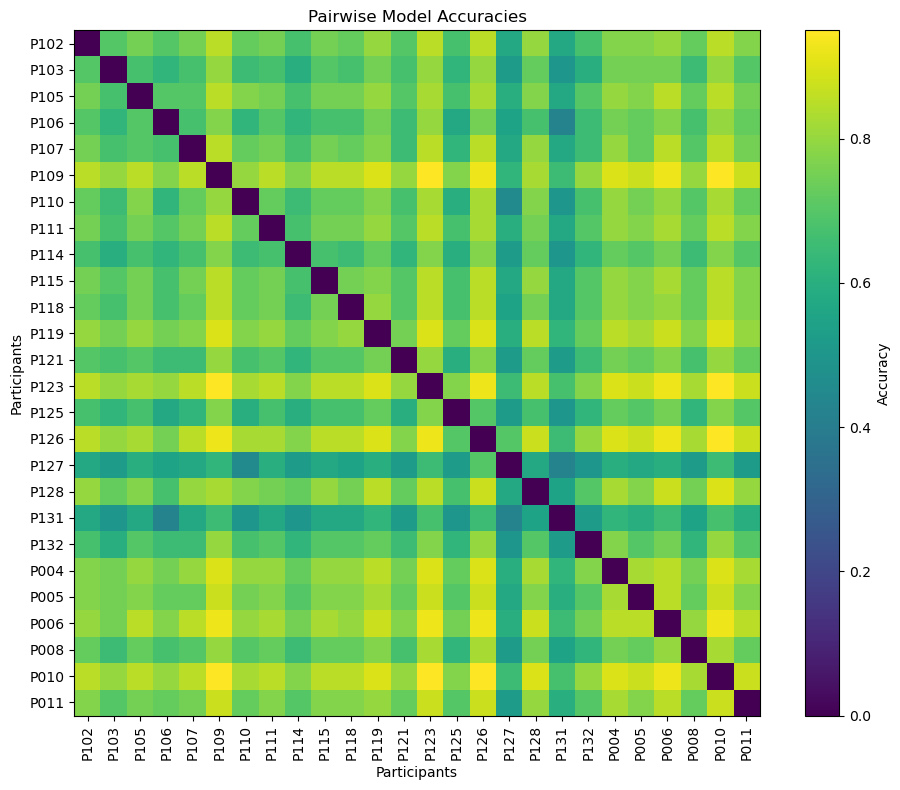

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(pairwise_model_HOTaccuracies_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Accuracy')
plt.xlabel('Participants')
plt.ylabel('Participants')
plt.title('Pairwise Model Accuracies')
plt.xticks(ticks=np.arange(len(participants)), labels=participants, rotation=90)
plt.yticks(ticks=np.arange(len(participants)), labels=participants)
plt.tight_layout()
plt.show()


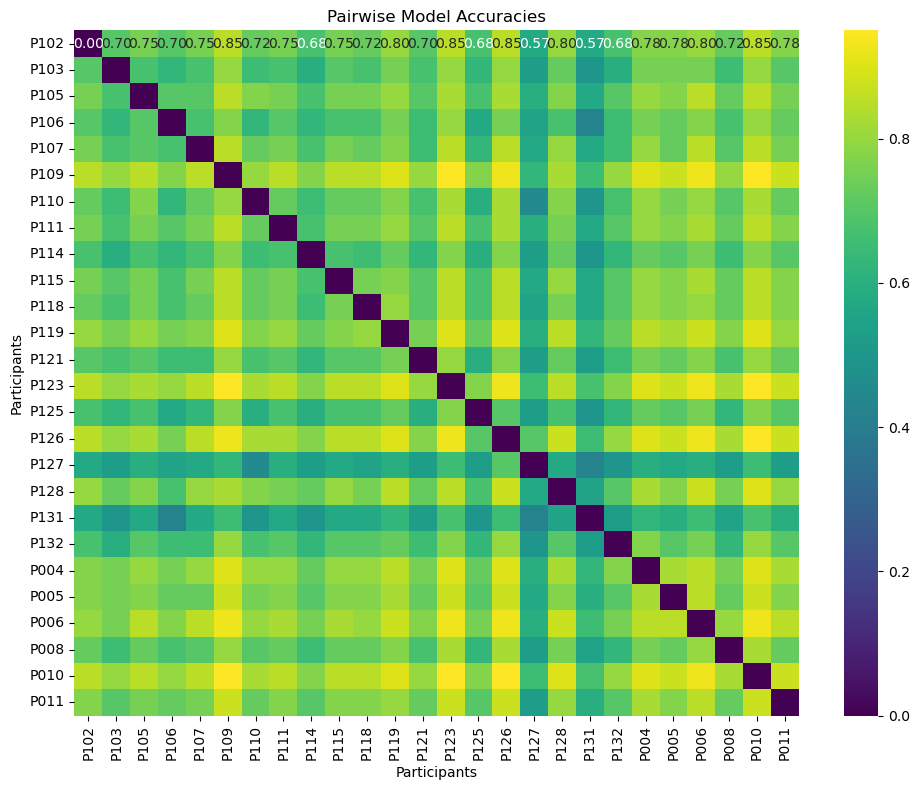

In [60]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(pairwise_model_HOTaccuracies_matrix, cmap='viridis', annot=True, fmt=".2f", xticklabels=participants, yticklabels=participants)
plt.xlabel('Participants')
plt.ylabel('Participants')
plt.title('Pairwise Model Accuracies')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


<Figure size 1000x800 with 0 Axes>

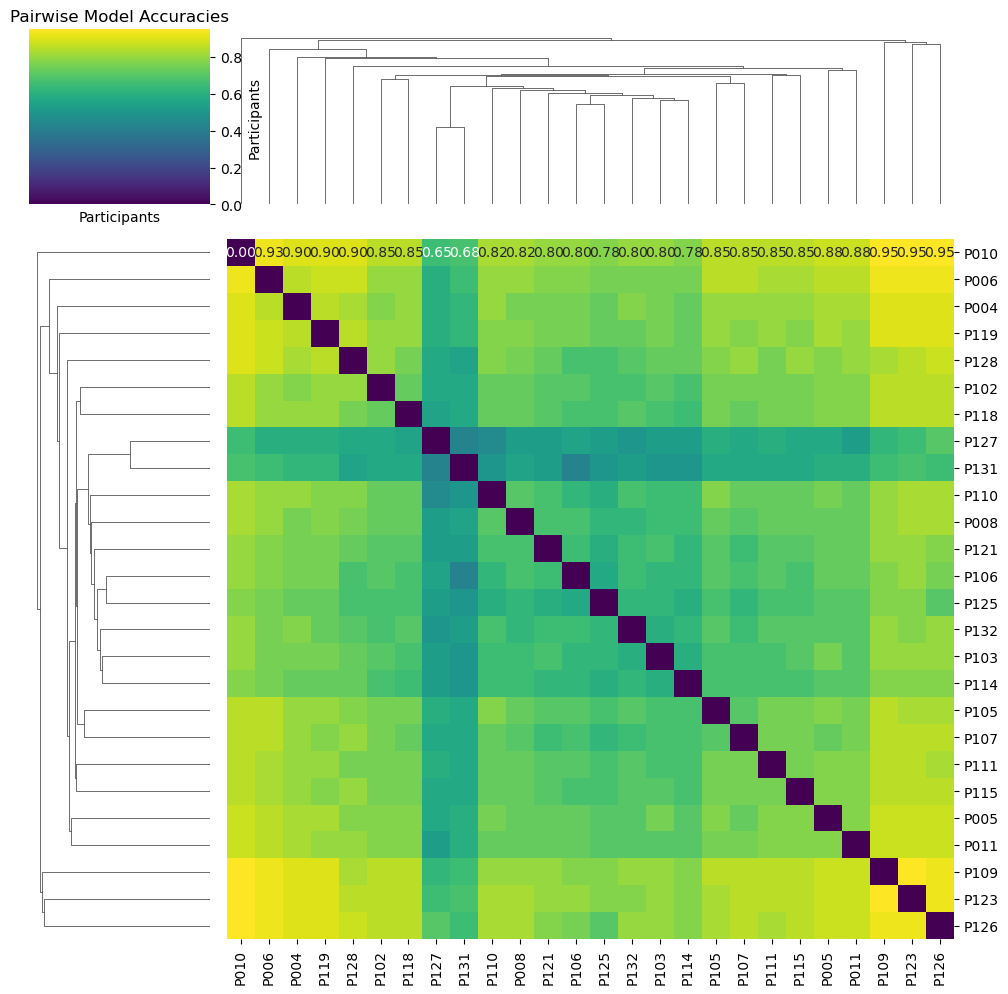

In [61]:
plt.figure(figsize=(10, 8))
sns.clustermap(pairwise_model_HOTaccuracies_matrix, cmap='viridis', annot=True, fmt=".2f", xticklabels=participants, yticklabels=participants)
plt.xlabel('Participants')
plt.ylabel('Participants')
plt.title('Pairwise Model Accuracies')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


For HOU

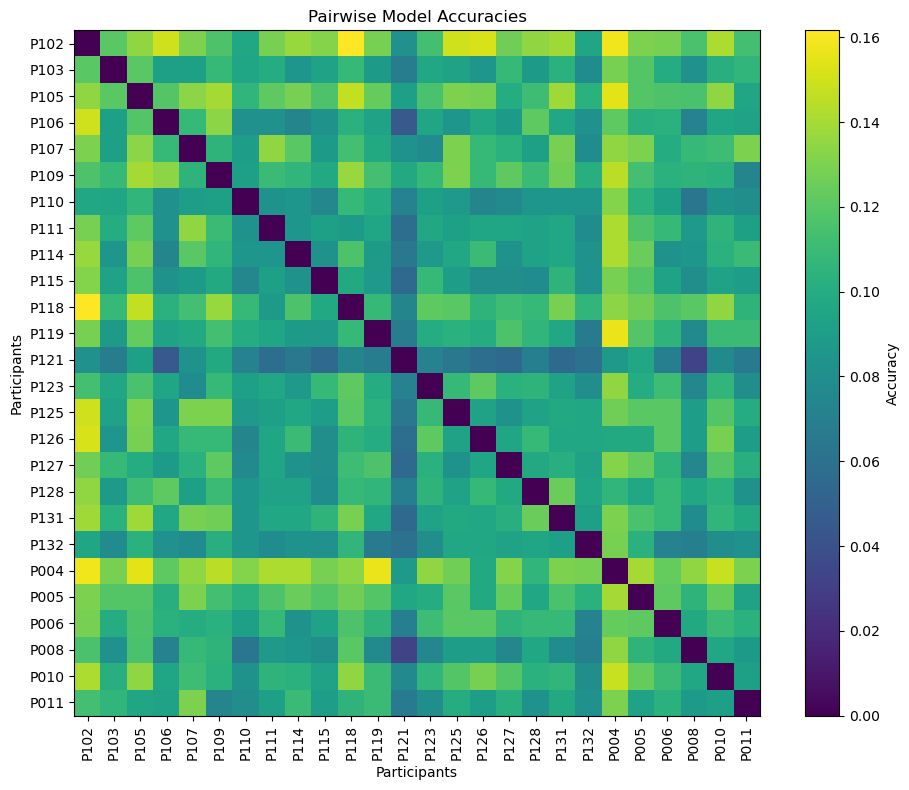

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(pairwise_model_HOUaccuracies_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Accuracy')
plt.xlabel('Participants')
plt.ylabel('Participants')
plt.title('Pairwise Model Accuracies')
plt.xticks(ticks=np.arange(len(participants)), labels=participants, rotation=90)
plt.yticks(ticks=np.arange(len(participants)), labels=participants)
plt.tight_layout()
plt.show()


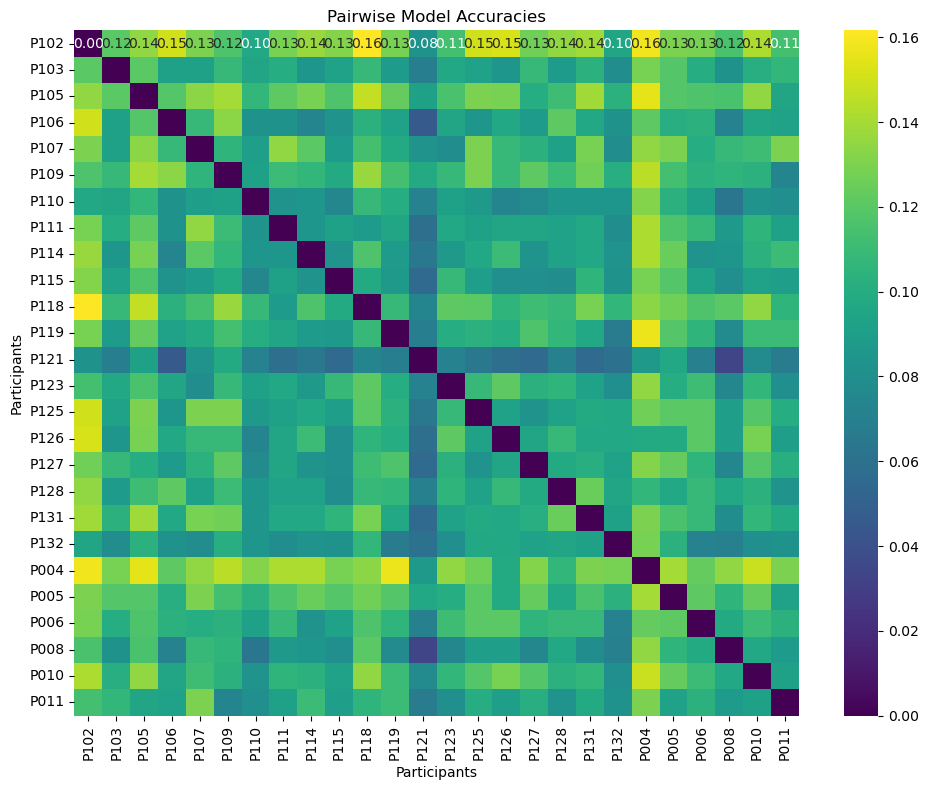

In [63]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(pairwise_model_HOUaccuracies_matrix, cmap='viridis', annot=True, fmt=".2f", xticklabels=participants, yticklabels=participants)
plt.xlabel('Participants')
plt.ylabel('Participants')
plt.title('Pairwise Model Accuracies')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


<Figure size 1000x800 with 0 Axes>

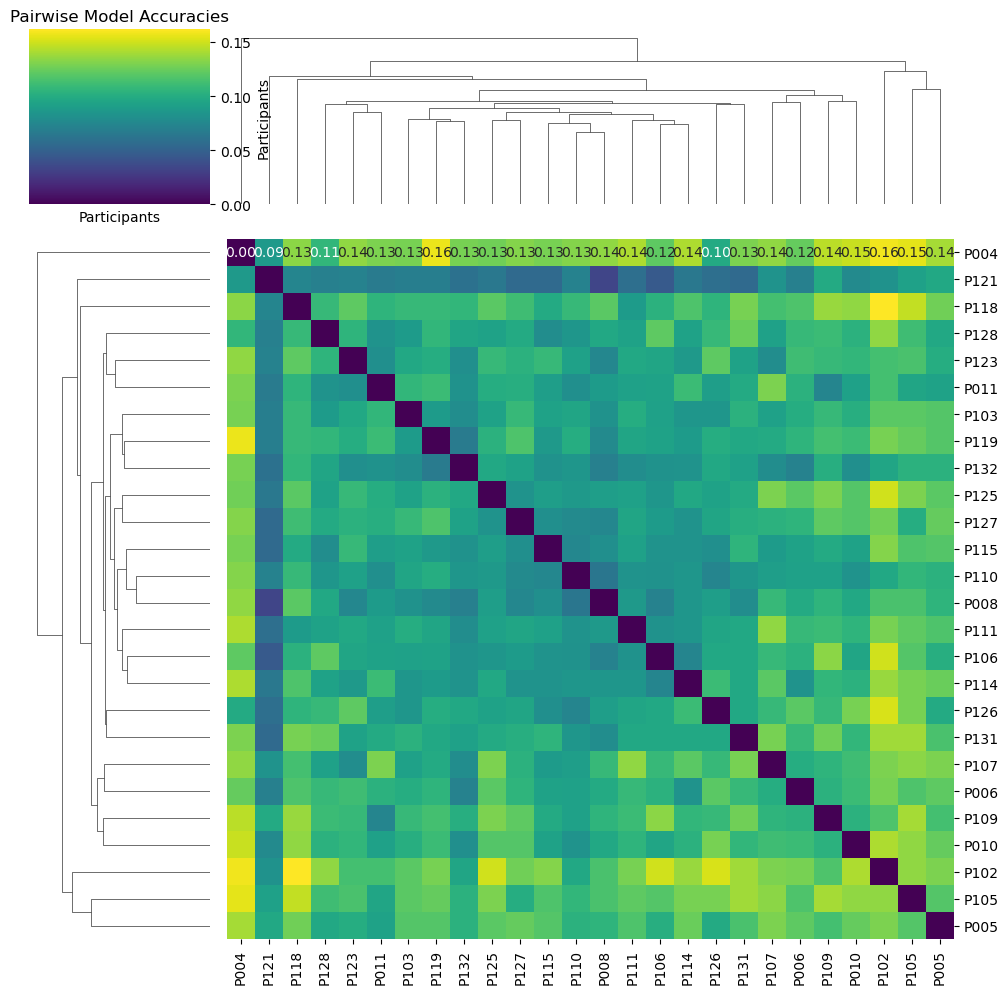

In [64]:
plt.figure(figsize=(10, 8))
sns.clustermap(pairwise_model_HOUaccuracies_matrix, cmap='viridis', annot=True, fmt=".2f", xticklabels=participants, yticklabels=participants)
plt.xlabel('Participants')
plt.ylabel('Participants')
plt.title('Pairwise Model Accuracies')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
